In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xtrack as xt
import xcoll as xc
import xobjects as xo
import xpart as xp

In [2]:
line = xt.Line.from_json('injection_thin_approx_ap2.json')
#line = xt.Line.from_json('lhc_run3_b1.json')

Loading line from dict:   0%|          | 0/31427 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
num_turns = 3000
num_particles = 500

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6
amplitude_adt = 0.12

In [4]:
print('Install collimator')
coll = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
line.collimators.install('tcsm.51932', coll)

#Make aperture for collimator and update line
coll_ap = xt.LimitRectEllipse(a=0.05, b=0.05, max_x=0.05, max_y=0.05) 
coll_ap_names = ['tcsm.51932_aper_upstream', 'tcsm.51932_aper_downstream']
coll_ap_idx = [line.element_names.index('tcsm.51932'), line.element_names.index('tcsm.51932') + 1]

max_length = max(max(map(len, line.element_names)), max(map(len, coll_ap_names)))
element_names = np.array(line.element_names, dtype=f'<U{max_length}')
names = np.array(coll_ap_names, dtype=f'<U{max_length}')
element_names = np.insert(element_names, coll_ap_idx, coll_ap_names)

insert_colls = {name: coll_ap for name in coll_ap_names}

line.element_names = element_names.tolist()
line.element_dict = {**line.element_dict, **insert_colls}

Install collimator


Slicing line:   0%|          | 0/30277 [00:00<?, ?it/s]

In [5]:
adt = xc.BlowUp.install(line, name=f'adt_H_blowup', at_s=line.get_s_position('adkcv.32171'), plane='H', stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=True)

In [6]:
df_with_coll = line.check_aperture()

Checking aperture:   0%|          | 0/30280 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


In [ ]:
line.build_tracker()
tw = line.twiss()
sigma_x = np.sqrt(nemitt_x*tw.betx)
sigma_y = np.sqrt(nemitt_y*tw.bety)

line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)
line.optimize_for_tracking()

# Start interaction record
impacts = xc.InteractionRecord.start(line=line, record_impacts=True)

Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data


In [8]:
line.scattering.disable()
part = xp.generate_matched_gaussian_bunch(num_particles=num_particles, total_intensity_particles=2.2e11,
                                          nemitt_x=3.5e-6, nemitt_y=3.5e-6, sigma_z=0.224, line=line) #Flat bottom: 0.224, flat top: 0.124

*** Maximum RMS bunch length 0.23305719224813928m.
... distance to target bunch length: -2.2400e-01
... distance to target bunch length: 4.2397e-03
... distance to target bunch length: 4.0509e-03
... distance to target bunch length: -5.4164e-03
... distance to target bunch length: 1.6934e-03
... distance to target bunch length: -3.8711e-04
... distance to target bunch length: 6.2540e-05
... distance to target bunch length: 1.9666e-06
... distance to target bunch length: -3.5749e-10
... distance to target bunch length: 9.4807e-08
--> Bunch length: 0.22399999964250905
--> Emittance: 0.34322710188738204


In [10]:
final_res = {}
prev_res = {}
dead_idx = []

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
for turn in range(num_turns):
    if turn%100==0:
        print(f'Turn {turn}')
    line.track(part, turn_by_turn_monitor='ONE_TURN_EBE')
    res = line.record_last_track
    ids = part.particle_id[part.state<=0]
    if ids.size>0:
        for idx in ids:
            if idx not in dead_idx:
                dead_idx.append(idx)
                if turn not in final_res:
                    final_res[turn] = {}
                #this_idx = res.particle_id.index(idx)
                this_idx = int(np.where(np.any(res.particle_id==idx, axis=1))[0][0])
                final_res[turn][idx] = {
                    'x': res.x[this_idx].copy(),
                    'y': res.y[this_idx].copy()
                }
                if turn > 0:
                    if turn-1 not in final_res:
                        final_res[turn-1] = {}
                    prev_idx = int(np.where(np.any(prev_res['pid']==idx, axis=1))[0][0])
                    final_res[turn-1][idx] = {
                        'x': prev_res['x'][prev_idx].copy(),
                        'y': prev_res['y'][prev_idx].copy()
                    }
    prev_res = {
        'x': res.x.copy(),
        'y': res.y.copy(),
        'pid': res.particle_id.copy()
    }
    del res
adt.deactivate()
line.scattering.disable()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Turn 0
Turn 100
Turn 200
Turn 300
Turn 400
Turn 500
Turn 600
Turn 700
Turn 800
Turn 900
Turn 1000
Turn 1100
Turn 1200
Turn 1300
Turn 1400
Turn 1500
Turn 1600
Turn 1700
Turn 1800
Turn 1900
Turn 2000
Turn 2100
Turn 2200
Turn 2300
Turn 2400
Turn 2500
Turn 2600
Turn 2700
Turn 2800
Turn 2900


In [11]:
final_res.keys()

dict_keys([87, 86, 116, 115, 141, 140, 143, 142, 147, 146, 148, 160, 159, 161, 178, 177, 186, 185, 206, 205, 215, 214, 222, 221, 235, 234, 269, 268, 273, 272, 279, 278, 283, 282, 285, 284, 287, 286, 295, 294, 296, 300, 299, 301, 303, 302, 307, 306, 315, 314, 316, 324, 323, 331, 330, 334, 333, 336, 335, 337, 341, 340, 345, 344, 346, 353, 352, 358, 357, 359, 365, 364, 375, 374, 382, 381, 389, 388, 390, 407, 406, 410, 409, 413, 412, 423, 422, 438, 437, 440, 439, 442, 441, 444, 443, 446, 445, 447, 450, 449, 452, 451, 457, 456, 459, 458, 463, 462, 465, 464, 466, 467, 474, 473, 477, 476, 478, 479, 486, 485, 488, 487, 505, 504, 513, 512, 514, 520, 519, 522, 521, 523, 524, 529, 528, 538, 537, 541, 540, 542, 548, 547, 550, 549, 552, 551, 560, 559, 562, 561, 566, 565, 567, 577, 576, 579, 578, 586, 585, 587, 589, 588, 591, 590, 596, 595, 597, 606, 605, 607, 612, 611, 621, 620, 629, 628, 633, 632, 638, 637, 639, 649, 648, 654, 653, 656, 655, 657, 661, 660, 664, 663, 665, 673, 672, 676, 675, 679, 6

,turn,collimator,interaction_type,id_before,s_before,x_before,px_before,y_before,py_before,zeta_before,...,y_after,py_after,zeta_after,delta_after,energy_after,mass_after,charge_after,z_after,a_after,pdgid_after
0,67,tcsm.51932,Enter Jaw L,313,0.311756,0.000000,0.000144,0.001036,-0.000036,-0.150249,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
1,127,tcsm.51932,Enter Jaw L,328,1.612267,0.000000,0.000249,0.003473,-0.000028,-0.186926,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
2,137,tcsm.51932,Enter Jaw R,203,0.000000,0.000142,0.000192,0.004464,-0.000107,0.034222,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
3,146,tcsm.51932,Enter Jaw R,0,1.691726,-0.000000,0.000150,0.003656,-0.000111,-0.465186,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
4,155,tcsm.51932,Enter Jaw L,282,0.000000,0.000072,0.000236,-0.007891,0.000134,-0.136882,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2905,tcsm.51932,Enter Jaw R,220,1.027678,-0.000000,0.000274,0.002831,-0.000039,-0.190482,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
509,2960,tcsm.51932,Enter Jaw R,324,0.000000,0.000119,0.000186,0.005589,-0.000098,-0.097389,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
510,2971,tcsm.51932,Enter Jaw R,144,0.495834,-0.000000,0.000231,0.000646,-0.000047,0.068803,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1
511,2973,tcsm.51932,Enter Jaw L,144,0.000000,0.003141,0.000569,-0.005617,0.000135,0.052482,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1


In [13]:
impacts_df = impacts.to_pandas()

hit_ids = np.unique(impacts_df.id_before)
died_on_aperture = part.particle_id[part.state==0]

pids = np.intersect1d(hit_ids, died_on_aperture)

{int(pid): int(impacts_df.turn[impacts_df.id_before==pid].min()) for pid in pids}

{7: 116,
 9: 621,
 11: 955,
 13: 2733,
 18: 1492,
 19: 1023,
 21: 1640,
 24: 1854,
 25: 591,
 27: 438,
 30: 1127,
 31: 1613,
 33: 2229,
 41: 1441,
 42: 771,
 43: 2982,
 44: 2721,
 45: 589,
 46: 444,
 50: 1480,
 58: 2214,
 60: 513,
 63: 148,
 67: 1843,
 78: 467,
 82: 1510,
 88: 287,
 90: 514,
 93: 1338,
 112: 727,
 113: 2382,
 119: 606,
 126: 639,
 127: 483,
 128: 1118,
 129: 295,
 134: 1600,
 139: 967,
 140: 522,
 141: 215,
 149: 1485,
 153: 375,
 154: 1646,
 158: 1364,
 161: 1455,
 162: 1527,
 169: 1659,
 177: 629,
 178: 1210,
 181: 1278,
 182: 597,
 183: 1973,
 188: 1943,
 191: 2727,
 201: 1338,
 205: 1043,
 210: 1044,
 211: 273,
 215: 727,
 216: 1106,
 221: 765,
 225: 143,
 226: 727,
 230: 886,
 233: 315,
 235: 717,
 244: 2214,
 247: 1532,
 250: 577,
 252: 389,
 260: 2164,
 261: 1221,
 275: 160,
 276: 336,
 281: 816,
 282: 1033,
 287: 1532,
 291: 1386,
 295: 446,
 297: 1397,
 308: 1538,
 309: 1195,
 311: 2791,
 315: 1084,
 317: 1689,
 319: 679,
 332: 1468,
 335: 1456,
 341: 1175,
 3

end_id=np.int64(16270), pid=44, turn=2721


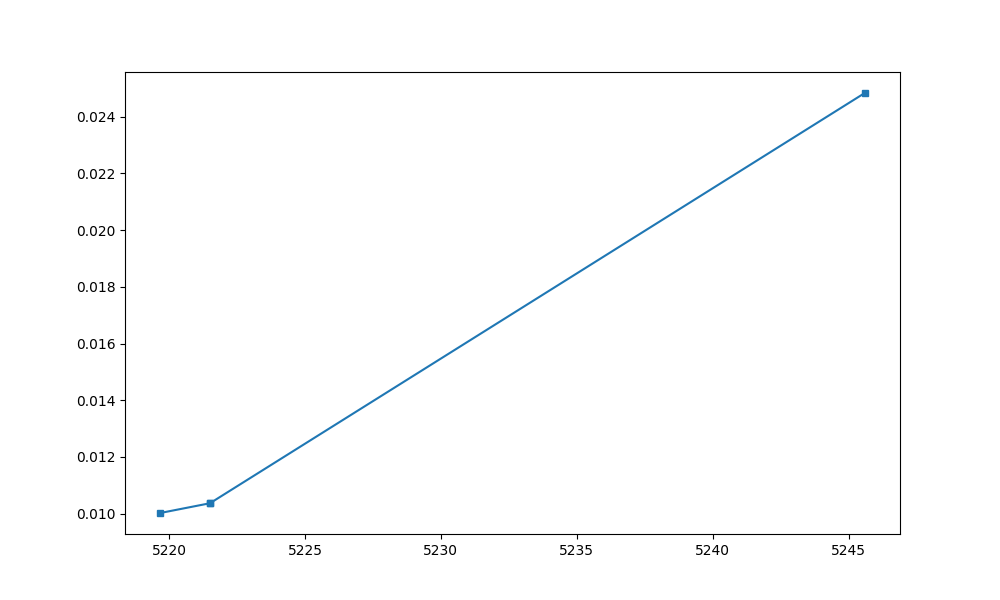

In [73]:
%matplotlib ipympl

coll_id = impacts._coll_ids['tcsm.51932']

hit_ids = np.unique(impacts.to_pandas().id_before)
died_on_aperture = part.particle_id[part.state==0]

pids = np.intersect1d(hit_ids, died_on_aperture)
turns = {int(pid): int(impacts_df.turn[impacts_df.id_before==pid].min()) for pid in pids}

fig, ax = plt.subplots(figsize=(10, 6))
for i, (pid, turn) in enumerate(turns.items()):
    if i==16:
        end_id = part.at_element[part.particle_id==pid][0]
        if turn+1 in final_res and pid in final_res[turn+1]:
            if turn in final_res and pid in final_res[turn]:
                ax.plot(line.get_table().s[coll_id:], final_res[turn][pid]['x'][coll_id:], marker ='s', markersize=5)
                ax.plot(line.get_table().s[:end_id+1], final_res[turn+1][pid]['x'][:end_id+1], marker ='s', markersize=5)
        else:
            print(f"{end_id=}, {pid=}, {turn=}")
            ax.plot(line.get_table().s[coll_id:end_id+1], final_res[turn][pid]['x'][coll_id:end_id+1], marker ='s', markersize=5)
plt.show()

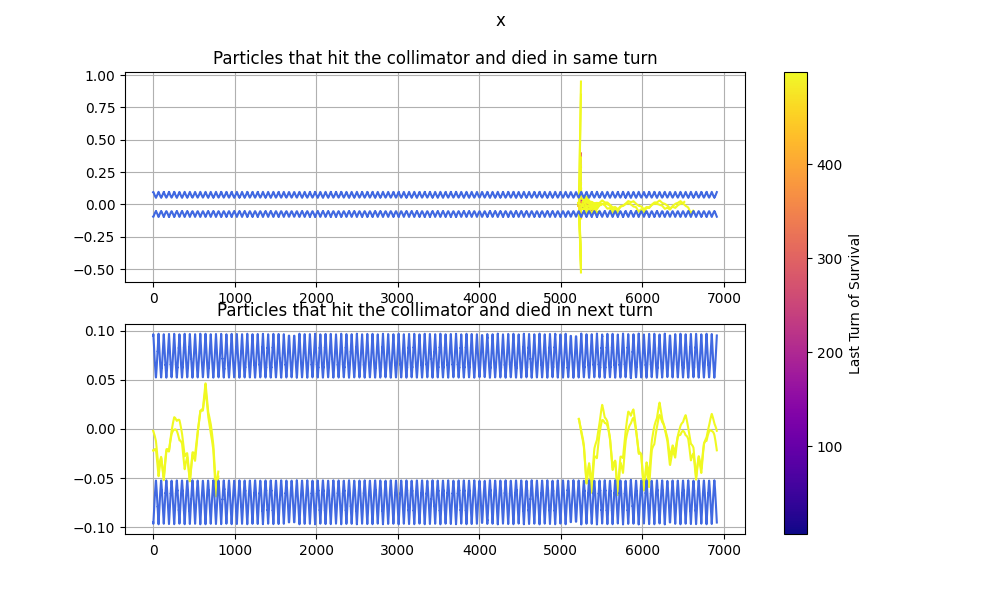

In [116]:
%matplotlib ipympl

coll_id = impacts._coll_ids['tcsm.51932']

hit_ids = np.unique(impacts.to_pandas().id_before)
died_on_aperture = part.particle_id[part.state==0]

pids = np.intersect1d(hit_ids, died_on_aperture)
turns = {int(pid): int(impacts_df.turn[impacts_df.id_before==pid].min()) for pid in pids}

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

cmap = plt.cm.plasma # Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm', etc.)
norm = plt.Normalize(vmin=min(turns), vmax=max(turns))

for (pid, turn) in turns.items():
    end_id = part.at_element[part.particle_id==pid][0]
    color = cmap(norm(turn)) 
    if turn+1 in final_res and pid in final_res[turn+1]:
        if turn in final_res and pid in final_res[turn]:
            ax[1].plot(line.get_table().s[coll_id:], final_res[turn][pid]['x'][coll_id:], color=color)
            ax[1].plot(line.get_table().s[:end_id+1], final_res[turn+1][pid]['x'][:end_id+1], color=color)
    else:
        if turn in final_res and pid in final_res[turn]:
            ax[0].plot(line.get_table().s[coll_id:end_id+1], final_res[turn][pid]['x'][coll_id:end_id+1], color=color)
            
ax[0].set_title('Particles that hit the collimator and died in same turn')
ax[1].set_title('Particles that hit the collimator and died in next turn')
for axis in ax:
    axis.grid()
    axis.plot(tw.s, 5*sigma_x, color='royalblue', linestyle='-')
    axis.plot(tw.s, -5*sigma_x, color='royalblue', linestyle='-')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label="Last Turn of Survival")

plt.suptitle('x')
plt.show()

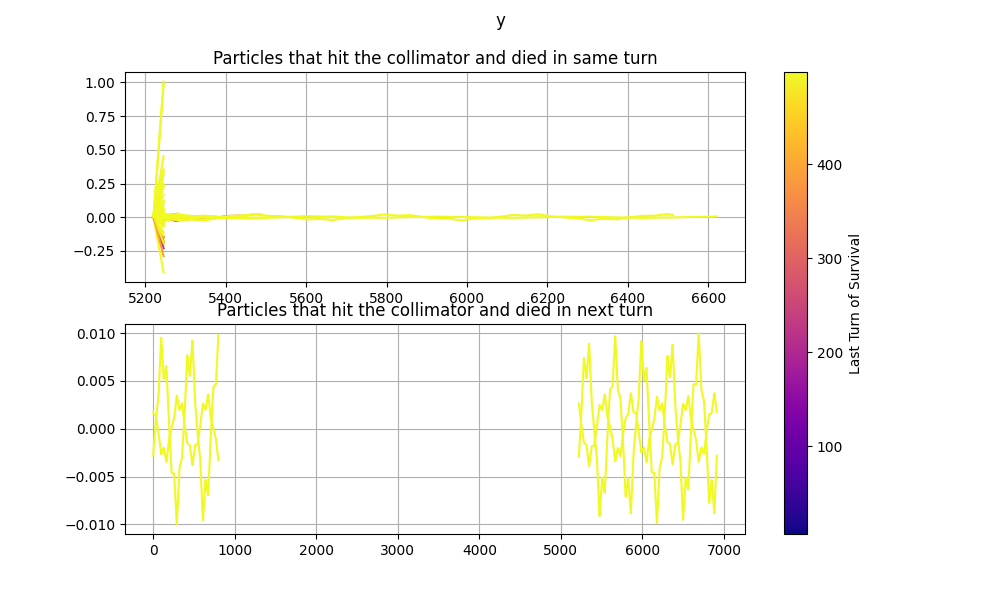

In [107]:
%matplotlib ipympl

coll_id = impacts._coll_ids['tcsm.51932']

hit_ids = np.unique(impacts.to_pandas().id_before)
died_on_aperture = part.particle_id[part.state==0]

pids = np.intersect1d(hit_ids, died_on_aperture)
turns = {int(pid): int(impacts_df.turn[impacts_df.id_before==pid].min()) for pid in pids}

cmap = plt.cm.plasma # Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm', etc.)
norm = plt.Normalize(vmin=min(turns), vmax=max(turns)) 

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for (pid, turn) in turns.items():
    end_id = part.at_element[part.particle_id==pid][0]
    color = cmap(norm(turn)) 
    if turn+1 in final_res and pid in final_res[turn+1]:
        if turn in final_res and pid in final_res[turn]:
            ax[1].plot(line.get_table().s[coll_id:], final_res[turn][pid]['y'][coll_id:], color=color)
            ax[1].plot(line.get_table().s[:end_id+1], final_res[turn+1][pid]['y'][:end_id+1], color=color)
    else:
        if turn in final_res and pid in final_res[turn]:
            ax[0].plot(line.get_table().s[coll_id:end_id+1], final_res[turn][pid]['y'][coll_id:end_id+1], color=color)
            
ax[0].set_title('Particles that hit the collimator and died in same turn')
ax[1].set_title('Particles that hit the collimator and died in next turn')
for axis in ax:
    axis.grid()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar

cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label="Last Turn of Survival")

plt.suptitle('y')
plt.show()

In [ ]:
complete_impact = {int(pid): list(impacts_df.turn[impacts_df.id_before==pid]) for pid in pids} #Some particles hit the collimator multiple times
for pid in complete_impact:
    print(f'Particle {pid} hit the collimator at turns {complete_impact[pid]}')

Particle 7 hit the collimator at turns [116]
Particle 9 hit the collimator at turns [621]
Particle 11 hit the collimator at turns [955]
Particle 13 hit the collimator at turns [2733]
Particle 18 hit the collimator at turns [1492]
Particle 19 hit the collimator at turns [1023]
Particle 21 hit the collimator at turns [1640, 1642]
Particle 24 hit the collimator at turns [1854, 1856]
Particle 25 hit the collimator at turns [591]
Particle 27 hit the collimator at turns [438]
Particle 30 hit the collimator at turns [1127]
Particle 31 hit the collimator at turns [1613]
Particle 33 hit the collimator at turns [2229]
Particle 41 hit the collimator at turns [1441]
Particle 42 hit the collimator at turns [771]
Particle 43 hit the collimator at turns [2982]
Particle 44 hit the collimator at turns [2721]
Particle 45 hit the collimator at turns [589]
Particle 46 hit the collimator at turns [444]
Particle 50 hit the collimator at turns [1480]
Particle 58 hit the collimator at turns [2214]
Particle 60

In [114]:
sigma_x = np.sqrt(nemitt_x*tw.betx)
sigma_y = np.sqrt(nemitt_y*tw.bety)

In [15]:
import pickle

In [108]:
with open('final_res.pkl', 'wb') as f:
    pickle.dump(final_res, f)